# model

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from lightgbm import LGBMRegressor, plot_importance
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [2]:
# knob 종류 및 바운드
# aof

knobs_aof = {
    
    "hash-max-ziplist-entries":     (256, 751), 
    "hash-max-ziplist-value": (16, 257),
    "activerehashing": ('yes', 'no'),  ##yes
    "hz": (1, 41),
    "dynamic-hz": ('yes', 'no'),
    
    # appendonly 제외
    'appendfsync' :('always', 'everysec', 'no'),
    'auto-aof-rewrite-percentage': (50, 200),
    'auto-aof-rewrite-min-size': (16, 256),
    'no-appendfsync-on-rewrite': ('yes', 'no'),
    'aof-rewrite-incremental-fsync': ('yes', 'no'),
    'aof-use-rdb-preamble': ('yes', 'no'),


    "activedefrag": ('yes','no'),  
    "active-defrag-threshold-lower": (1, 31),
    "active-defrag-threshold-upper": (70, 101),
    "active-defrag-cycle-min": (1, 31),
    "active-defrag-cycle-max": (70, 91),
    
    "maxmemory": (1000, 2900),   ##"volatile-lru"
    "maxmemory-policy":     ("volatile-lru", "allkeys-lru", "volatile-lfu", "allkeys-lfu", 
                             "volatile-random","allkeys-random", "volatile-ttl", "noeviction"),
    "maxmemory-samples": (3, 7),
    
    "lazyfree-lazy-eviction": ('yes', 'no'),
    "lazyfree-lazy-expire": ('yes', 'no'),
    "lazyfree-lazy-server-del": ('yes', 'no')
}

knobs_list = list(knobs_aof.keys())
knobs_bound = list(knobs_aof.values())

## 데이터 전처리
* 이상치 파악
* test, train 데이터 잘 나뉘어졌는지 확인

In [3]:
# internal role == master 인 부분 인덱스 계산
file_dir = '../data/'
file_name = 'internal_metrics_r10000_aof2.csv'

internal_csv = pd.read_csv(file_dir+file_name)
idx_role_null = internal_csv['role'] == 'master'

In [4]:
# config(knob) data
config_df = pd.read_csv("../data/result_config_r10000_aof.csv", sep=',')

# 1250 개 추출
config_df = config_df.iloc[0:1000,:]
config_df.shape

# external(throughput) data
# external_df = pd.read_csv("./data/external_metrics0.csv", sep=',')
external_df = pd.read_csv("../data/external_metrics_r10000_aof2.csv", sep=',')
# 1250 개 추출
external_df = external_df.iloc[0:1000,:]
external_df.shape

(1000, 39)

In [5]:
# config(knog), external(throughput) 데이터 하나의 프레임으로 결합
dataset = config_df
dataset['throughput'] = external_df['Gets_KB/sec']

In [6]:
# 결측치 처리 
dataset_nan = dataset.copy()
dataset['activedefrag'].fillna(value='no', inplace=True)  # activedefrag no 채우기
dataset = dataset.fillna(value = 0)  # 전부 0으로 채움

In [7]:
# role == master 제외
dataset = dataset[idx_role_null]

In [8]:
dataset

,appendonly,appendfsync,auto-aof-rewrite-percentage,auto-aof-rewrite-min-size,no-appendfsync-on-rewrite,aof-rewrite-incremental-fsync,aof-use-rdb-preamble,save0_0,save0_1,save1_0,...,maxmemory-samples,lazyfree-lazy-eviction,lazyfree-lazy-expire,lazyfree-lazy-server-del,hash-max-ziplist-entries,hash-max-ziplist-value,activerehashing,hz,dynamic-hz,throughput
0,yes,everysec,155,118mb,no,yes,yes,0.0,0.0,0.0,...,7,yes,yes,no,730,184,no,6,no,51111.81
1,yes,no,93,244mb,no,yes,yes,0.0,0.0,0.0,...,6,no,yes,yes,439,216,yes,18,yes,45144.89
2,yes,always,175,134mb,no,no,yes,0.0,0.0,0.0,...,5,yes,yes,yes,387,241,yes,16,yes,17.56
3,yes,no,174,56mb,no,yes,no,0.0,0.0,0.0,...,3,yes,yes,yes,475,187,no,2,no,41590.07
4,yes,always,145,178mb,no,no,yes,0.0,0.0,0.0,...,3,yes,no,no,623,33,no,7,no,18.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,yes,no,161,201mb,yes,yes,yes,0.0,0.0,0.0,...,3,no,yes,no,429,49,yes,5,no,35386.89
996,yes,no,192,69mb,no,no,yes,0.0,0.0,0.0,...,5,no,yes,no,698,67,yes,27,no,44235.75
997,yes,everysec,55,113mb,no,yes,no,0.0,0.0,0.0,...,5,no,yes,no,402,51,no,24,no,44972.83
998,yes,always,192,150mb,no,no,yes,0.0,0.0,0.0,...,6,no,no,yes,577,189,yes,37,no,18.48


In [9]:
# maxmemory knob 단위(mb) 처리
dataset['maxmemory']  = dataset['maxmemory'].str.strip('mb')
dataset['maxmemory'] = pd.to_numeric(dataset['maxmemory'])

# auto-aof-rewrite-min-size knob 단위(mb) 처리
dataset['auto-aof-rewrite-min-size']  = dataset['auto-aof-rewrite-min-size'].str.strip('mb')
dataset['auto-aof-rewrite-min-size'] = pd.to_numeric(dataset['auto-aof-rewrite-min-size'])

In [10]:
# Object 변수 categorical 로 변경 (LightGBM에 바로 넣기 위해)
category_knob = []

for knob in dataset:
    if dataset[knob].dtype == 'O':  # Object인 경우 category 형으로 변경
        dataset[knob] = dataset[knob].astype('category')
        if knob in knobs_list:
            category_knob.append(knob)

In [11]:
# 설정한 knob들만 추출
extract_knobs_list = knobs_list.copy()
extract_knobs_list.append('throughput')  # target 값 추가

dataset = dataset[extract_knobs_list]

In [12]:
dataset.head(3)

,hash-max-ziplist-entries,hash-max-ziplist-value,activerehashing,hz,dynamic-hz,appendfsync,auto-aof-rewrite-percentage,auto-aof-rewrite-min-size,no-appendfsync-on-rewrite,aof-rewrite-incremental-fsync,...,active-defrag-threshold-upper,active-defrag-cycle-min,active-defrag-cycle-max,maxmemory,maxmemory-policy,maxmemory-samples,lazyfree-lazy-eviction,lazyfree-lazy-expire,lazyfree-lazy-server-del,throughput
0,730,184,no,6,no,everysec,155,118,no,yes,...,74.0,22.0,85.0,1000,volatile-lru,7,yes,yes,no,51111.81
1,439,216,yes,18,yes,no,93,244,no,yes,...,0.0,0.0,0.0,1800,noeviction,6,no,yes,yes,45144.89
2,387,241,yes,16,yes,always,175,134,no,no,...,0.0,0.0,0.0,2500,volatile-lfu,5,yes,yes,yes,17.56


### 이상치 처리

In [13]:
# # 이상치 인덱스 반환 함수
# def get_outlier(df=None, column=None, weight=1.5):
    
#     # target 값과 상관관계가 높은 열을 우선적으로 진행
#     quantile_25 = np.percentile(df[column].values, 25)
#     quantile_75 = np.percentile(df[column].values, 75)

#     IQR = quantile_75 - quantile_25
#     IQR_weight = IQR*weight

#     lowest = quantile_25 - IQR_weight
#     highest = quantile_75 + IQR_weight

#     outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
#     return outlier_idx

In [14]:
# import seaborn as sns
# sns.boxplot(dataset['throughput'])

In [15]:
# outlier_index = get_outlier(dataset, 'throughput')

# # 이상치 제거
# dataset.drop(outlier_index, axis=0, inplace = True)
# sns.boxplot(dataset['throughput'])

In [16]:
# 원핫인코딩
dataset_ohe = pd.get_dummies(dataset, columns = category_knob)
dataset_ohe.head(3)

,hash-max-ziplist-entries,hash-max-ziplist-value,hz,auto-aof-rewrite-percentage,auto-aof-rewrite-min-size,active-defrag-threshold-lower,active-defrag-threshold-upper,active-defrag-cycle-min,active-defrag-cycle-max,maxmemory,...,lazyfree-lazy-eviction_no,lazyfree-lazy-eviction_yes,lazyfree-lazy-expire_no,lazyfree-lazy-expire_yes,lazyfree-lazy-server-del_no,lazyfree-lazy-server-del_yes,activerehashing_no,activerehashing_yes,dynamic-hz_no,dynamic-hz_yes
0,730,184,6,155,118,29.0,74.0,22.0,85.0,1000,...,0,1,0,1,1,0,1,0,1,0
1,439,216,18,93,244,0.0,0.0,0.0,0.0,1800,...,1,0,0,1,0,1,0,1,0,1
2,387,241,16,175,134,0.0,0.0,0.0,0.0,2500,...,0,1,0,1,0,1,0,1,0,1


In [17]:
dataset_ohe.drop(columns = ['throughput'])

,hash-max-ziplist-entries,hash-max-ziplist-value,hz,auto-aof-rewrite-percentage,auto-aof-rewrite-min-size,active-defrag-threshold-lower,active-defrag-threshold-upper,active-defrag-cycle-min,active-defrag-cycle-max,maxmemory,...,lazyfree-lazy-eviction_no,lazyfree-lazy-eviction_yes,lazyfree-lazy-expire_no,lazyfree-lazy-expire_yes,lazyfree-lazy-server-del_no,lazyfree-lazy-server-del_yes,activerehashing_no,activerehashing_yes,dynamic-hz_no,dynamic-hz_yes
0,730,184,6,155,118,29.0,74.0,22.0,85.0,1000,...,0,1,0,1,1,0,1,0,1,0
1,439,216,18,93,244,0.0,0.0,0.0,0.0,1800,...,1,0,0,1,0,1,0,1,0,1
2,387,241,16,175,134,0.0,0.0,0.0,0.0,2500,...,0,1,0,1,0,1,0,1,0,1
3,475,187,2,174,56,19.0,71.0,7.0,79.0,2100,...,0,1,0,1,0,1,1,0,1,0
4,623,33,7,145,178,16.0,73.0,27.0,87.0,1400,...,0,1,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,429,49,5,161,201,0.0,0.0,0.0,0.0,1600,...,1,0,0,1,1,0,0,1,1,0
996,698,67,27,192,69,5.0,73.0,16.0,78.0,2400,...,1,0,0,1,1,0,0,1,1,0
997,402,51,24,55,113,0.0,0.0,0.0,0.0,1800,...,1,0,0,1,1,0,1,0,1,0
998,577,189,37,192,150,29.0,73.0,24.0,87.0,1000,...,1,0,1,0,0,1,0,1,1,0


### test, train 데이터 분리

In [18]:
# #  정확도 확인용 train 8, test 2
# X_train_val, X_test, y_train_val, y_test = train_test_split(dataset.iloc[:,:-1]
#                                                     , dataset['throughput'] 
#                                                     ,test_size=0.2
#                                                    , random_state = 156)

# # train 8 val 2
# X_train, X_val, y_train, y_val = train_test_split(X_train_val
#                                                     , y_train_val 
#                                                     ,test_size=0.2
#                                                    , random_state = 156)


# 전체 데이터 train 8, test 2
X_train, X_test, y_train, y_test = train_test_split(dataset_ohe.drop(columns = ['throughput'], axis=1)
                                                    , dataset['throughput'] 
                                                    ,test_size=0.2
                                                   , random_state = 156)


In [19]:
# X_train 확인
X_train.head()

,hash-max-ziplist-entries,hash-max-ziplist-value,hz,auto-aof-rewrite-percentage,auto-aof-rewrite-min-size,active-defrag-threshold-lower,active-defrag-threshold-upper,active-defrag-cycle-min,active-defrag-cycle-max,maxmemory,...,lazyfree-lazy-eviction_no,lazyfree-lazy-eviction_yes,lazyfree-lazy-expire_no,lazyfree-lazy-expire_yes,lazyfree-lazy-server-del_no,lazyfree-lazy-server-del_yes,activerehashing_no,activerehashing_yes,dynamic-hz_no,dynamic-hz_yes
509,368,107,35,81,105,0.0,0.0,0.0,0.0,2400,...,0,1,1,0,0,1,1,0,0,1
934,355,73,22,144,121,5.0,92.0,22.0,85.0,1300,...,1,0,0,1,1,0,0,1,0,1
82,559,233,36,83,61,3.0,73.0,16.0,70.0,1200,...,1,0,0,1,0,1,0,1,1,0
935,476,202,30,156,189,0.0,0.0,0.0,0.0,2000,...,1,0,0,1,0,1,0,1,1,0
152,363,117,20,101,149,0.0,0.0,0.0,0.0,1900,...,1,0,0,1,0,1,1,0,0,1


In [20]:
# knob 리스트 인덱스 수정
knobs_list = X_train.columns.tolist()
# knobs_bound = list(knobs_rdb.values())

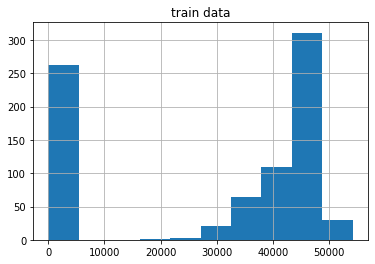

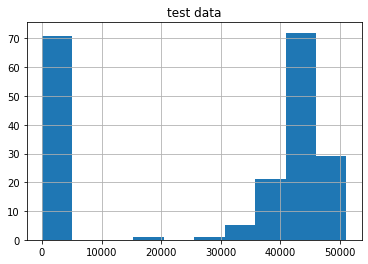

In [21]:
# test, train 에 비슷하게 분류됬는지 확인
y_train.hist()
plt.title('train data')
plt.show()

y_test.hist()
plt.title('test data')
plt.show()

## 회귀 모델 생성

In [22]:
# 성능 측정 함수 RMSLE(캐글에서 요구한 성능 평가 방법), MSE, RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error
# log 값 변환 시 NaN 등의 이슈로 log()가 아닌 log1p()를 이용해 RMSLE 계산 
def rmsle(y, pred):
    # log1p 변환
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    
    # squred 계산
    squared_error = (log_y-log_pred)**2
    
    # RMSE 계산
    rmsle = np.sqrt(np.mean(squared_error))
    
    return rmsle

# 사이킷런의 mean_square_error()를 이용해 RMSE 계산
def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

# MSE, RMSE, RMSLE를 모두 계산
def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    
    # MAE는 사이킷런의 mean_absolute_error()로 계산
    mae_val = mean_absolute_error(y, pred)
    
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))
    

# 모델 학습/테스트/ 데이터 세트를 입력하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    print('###', model.__class__.__name__, '###')
    evaluate_regr(y_test, pred)

In [23]:
# 모델 별로 평가 수행
lr_reg=LinearRegression()
ridge_reg=Ridge(alpha=10)
lasso_reg = Lasso()

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model, X_train, X_test, y_train, y_test)

### LinearRegression ###
RMSLE: 2.950, RMSE: 11498.869, MAE: 6185.355
### Ridge ###
RMSLE: 3.112, RMSE: 11444.310, MAE: 6538.025
### Lasso ###
RMSLE: 2.950, RMSE: 11496.579, MAE: 6183.221


이상치 제거 전
* LinearRegression 
RMSLE: 0.100, RMSE: 5281.652, MAE: 4166.291
* Ridge 
RMSLE: 0.100, RMSE: 5285.326, MAE: 4167.769
* Lasso 
RMSLE: 0.100, RMSE: 5281.738, MAE: 4165.988

이상치 제거 후
* LinearRegression 
RMSLE: 0.091, RMSE: 5293.044, MAE: 4559.048
* Ridge 
RMSLE: 0.091, RMSE: 5285.594, MAE: 4548.130
* Lasso 
RMSLE: 0.091, RMSE: 5291.237, MAE: 4556.475

---

# BO

모델은 같은 것을 사용한다.

knob_default 딕셔너리 


1. 목적함수에서 지정한 범위knob 값을 랜덤하게 추출
2. 목적함수에는 init_knob 값이 지정되어있고 나머지 값들은 들어오는 값으로 초기화
목적함수 들어가기 전에 미리 선택을 해야 한다. 범위에 대해서 

cluster0 값만준다.
목적함수에서는 받은 cluster0을 할당한다
할당되지 않은 Knob에 대해서는 knob_init를 참고하여 값을 할당한다. 

결과값을 init_dict에 할당한다. 
목적함세어는 받은 cluster1을 할당한다.
할당되지 않은 Knob에 대해서는 knob_init을 참고한다. 




In [24]:
def knob_to_dict(knob_dict):
    for key, val in knob_dict.items():
                
        if 'yes' in key:
            if val == 0:
                continue
            elif val == 1:
                print(key[:-4], end=' ')
                print('yes')
                continue
        elif 'no' in key:
            if val == 0:
                continue
            elif val == 1:
                print(key[:-3], end=' ')
                print('no')
                continue        
        
        if 'appendfsync' in key:
            if val == 0:
                continue

            elif val == 1:
                print('appendfsync',end=' ')
                print(key[12:])
            continue
        
        if 'maxmemory' in key:
            if 'policy' in key:
                if val == 1:
                    print('maxmemory-policy', end=' ')
                    print(key[17:])
                    continue
                
                elif val == 0:
                    continue
            
            elif len(key) == 9:
                print(key, end=' ')
                print(val, end='')
                print('mb')
                continue
        if 'auto-aof-rewrite-min-size' in key:
            print(key, end=' ')
            print(val, end='')
            print('mb')
            continue
                
        print(key, end=' ')
        print(val)

def knob_to_dict2(knob_dict):
    for key, val in knob_dict.items():
                        
        if 'save' in key:
            if key == 'rdb-save-incremental-fsync':
                print(key, end=' ')
                print(val)
                continue
            
            if key[6] == '0':
                print('save', end=' ')
                print(val, end=' ')
            elif key[6] == '1':
                print(val)
            continue
        
        if key == 'maxmemory':
            print(key, end=' ')
            print(val,end='')
            print('mb')
            continue
                        
        print(key, end=' ')
        print(val)


---

## 1. 목적함수- Ridge

In [25]:
noise_level = 0.1

def objective_func(knob_value, noise_level=noise_level):

    knob_dict = {}
    for knob in knobs_list: # 순서에 맞게 선언
        knob_dict[knob] = 'x'
    
#     print('###x 삽입###')
#     print(knob_dict)
    
    # knob_value 값 먼저 할당, knobs에 클러스터 이름 들어있다. 
    for idx,knob in enumerate(knobs):
        # 범주형 변수 처리
        if knob in category_knob:
            
            if knob == 'appendfsync':
                
                mmp_list = [
                        'appendfsync_always', 
                        'appendfsync_everysec',
                        'appendfsync_no', 
                ]
                mmp_list.remove(knob+'_'+knob_value[idx])  # 1할당된거 없앤다.
                knob_dict[knob+'_'+knob_value[idx]] = 1  # 1할당한다.
                
                for mmp in mmp_list:  # 1을 제외한 나머지 값들에 0 할당한다. 
                    knob_dict[mmp] = 0
                continue            
            
            elif knob_value[idx] == 'no':
                knob_dict[knob+'_no'] = 1
                knob_dict[knob+'_yes'] = 0
                
            elif knob_value[idx] == 'yes':
                knob_dict[knob+'_no'] = 0
                knob_dict[knob+'_yes'] = 1
            else:  # maxmemory-policy
                mmp_list = [
                        'maxmemory-policy_allkeys-lfu', 
                        'maxmemory-policy_allkeys-lru',
                        'maxmemory-policy_allkeys-random', 
                        'maxmemory-policy_noeviction',
                        'maxmemory-policy_volatile-lfu', 
                        'maxmemory-policy_volatile-lru',
                        'maxmemory-policy_volatile-random', 
                        'maxmemory-policy_volatile-ttl',
                ]
                mmp_list.remove(knob+'_'+knob_value[idx])
                knob_dict[knob+'_'+knob_value[idx]] = 1
                
                for mmp in mmp_list:
                    knob_dict[mmp] = 0
            continue
            
        # 수치형 변수는 할당    
        knob_dict[knob] = knob_value[idx]
    

    
#     print('##먼저할당##')
#     print(knob_dict)
    
    
    # 나머지 값 채우기 
    for knob ,knob_val in knob_dict.items():
        if knob_val == 'x':
            knob_dict[knob] = knobs_update[knob]
            
#     print('##나머지 update 반영 할당##')
#     print(knob_dict)
                    
    if 'activedefrag' in knob_dict:
        if knob_dict['activedefrag'] == 'no':  # activedefrag no인 경우 나머지 관련 knob들에 0할당!
            activ_var = ['active-defrag-threshold-lower', 'active-defrag-threshold-upper', 'active-defrag-cycle-min', 'active-defrag-cycle-max']
            for activ_knob in activ_var:
                knob_dict[activ_knob] = 0
    
    knob_df = pd.DataFrame(knob_dict, index=[0])  # 데이터 프레임으로 변환
            
    return -lasso_reg.predict(knob_df.iloc[:1,:])[0]


## 1.1 gp_minimize - Lasso

In [26]:
%matplotlib inline
print(__doc__)

import numpy as np
np.random.seed(237)
import matplotlib.pyplot as plt
from skopt.plots import plot_gaussian_process
from skopt import gp_minimize

Automatically created module for IPython interactive environment


In [31]:
cluster_table = {
    
        'clsuter0':[        
        # cluster1
        'active-defrag-threshold-lower',
        'active-defrag-cycle-min' ,
        'hash-max-ziplist-entries', 
        'hash-max-ziplist-value' ,
        'hz' ,
        'auto-aof-rewrite-percentage' ,
        'maxmemory' ,
        'dynamic-hz' ,
        'aof-use-rdb-preamble' ,
        'lazyfree-lazy-eviction', 
    ],
    
    'cluster1':[
        # cluster0
        'active-defrag-threshold-upper', 
        'active-defrag-cycle-max' ,
        'auto-aof-rewrite-min-size', 
        'maxmemory-samples',     
        'activerehashing',
        'no-appendfsync-on-rewrite',
        'aof-rewrite-incremental-fsync',
        'lazyfree-lazy-expire' ,
        'lazyfree-lazy-server-del',
     ],
}

knobs_update = {
    
    'hash-max-ziplist-entries':512,
    'hash-max-ziplist-value':64,
    'hz':10,
    'auto-aof-rewrite-percentage': 100,
    'auto-aof-rewrite-min-size':64 ,
    'active-defrag-threshold-lower':10,
    'active-defrag-threshold-upper':100,
    'active-defrag-cycle-min':5,
    'active-defrag-cycle-max':75,
    'maxmemory':0,
    'maxmemory-samples':5,
    'appendfsync_always':0,
    'appendfsync_everysec':1,
    'appendfsync_no':0,
    'no-appendfsync-on-rewrite_no':1,
    'no-appendfsync-on-rewrite_yes':0,
    'aof-rewrite-incremental-fsync_no':0,
    'aof-rewrite-incremental-fsync_yes':1,
    'aof-use-rdb-preamble_no':0,
    'aof-use-rdb-preamble_yes':1,
    'activedefrag_no':1,
    'activedefrag_yes':0,
    'maxmemory-policy_allkeys-lfu':0,
    'maxmemory-policy_allkeys-lru':0,
    'maxmemory-policy_allkeys-random':0,
    'maxmemory-policy_noeviction':1,
    'maxmemory-policy_volatile-lfu':0,
    'maxmemory-policy_volatile-lru':0,
    'maxmemory-policy_volatile-random':0,
    'maxmemory-policy_volatile-ttl':0,
    'lazyfree-lazy-eviction_no':1,
    'lazyfree-lazy-eviction_yes':0,
    'lazyfree-lazy-expire_no':1,
    'lazyfree-lazy-expire_yes':0,
    'lazyfree-lazy-server-del_no':1,
    'lazyfree-lazy-server-del_yes':0,
    'activerehashing_no':0,
    'activerehashing_yes':1,
    'dynamic-hz_no':0,
    'dynamic-hz_yes':1
}


In [32]:
res_result = []
knob_update_list = []

for i in range(1):
    print('###########{}##########'.format(i))
    
    iter_per_res = 0
    
    # 클러스터 내부 knob 별로 진행 
    for cluster, knobs in cluster_table.items():
        print('#####{}#####'.format(cluster))
        gp_knobs_bound = []

        # 1. 클러스터의 bound 생성
#         print('{} bound 생성'.format(cluster))
        for knob in knobs: 
            gp_knobs_bound.append(knobs_aof[knob])

#         print('{} gp 진행'.format(cluster))
        # 2. gp_minimize 진행
        res = gp_minimize(

                    objective_func,                  # 목적함수
                    gp_knobs_bound,      # bound
                    random_state=np.random.randint(1,1234),
            
                    acq_func="EI",      
                    n_calls=15,      # 총 반복 횟수
                    n_random_starts=5,    # 초기 랜덤 값
                    noise=0.1**2,       
        )
        

        # 결과 knob 값들
#         print('{} gp 완료'.format(cluster))
        res_result.append(res)
        gp_result = res.x
        iter_per_res = res.fun

        for idx,knob in enumerate(knobs):
            # 범주형 변수 처리
            if knob in category_knob:
                if gp_result[idx] == 'no':
                    knobs_update[knob+'_no'] = 1
                    knobs_update[knob+'_yes'] = 0

                elif gp_result[idx] == 'yes':
                    knobs_update[knob+'_no'] = 0
                    knobs_update[knob+'_yes'] = 1
                else:  # maxmemory-policy
                    mmp_list = [
                            'maxmemory-policy_allkeys-lfu', 
                            'maxmemory-policy_allkeys-lru',
                            'maxmemory-policy_allkeys-random', 
                            'maxmemory-policy_noeviction',
                            'maxmemory-policy_volatile-lfu', 
                            'maxmemory-policy_volatile-lru',
                            'maxmemory-policy_volatile-random', 
                            'maxmemory-policy_volatile-ttl',
                    ]
                    mmp_list.remove(knob+'_'+gp_result[idx])
                    knobs_update[knob+'_'+gp_result[idx]] = 1

                    for mmp in mmp_list:
                        knobs_update[mmp] = 0
                continue

            # 수치형 변수는 할당    
            knobs_update[knob] = gp_result[idx]
                
        knob_update_list.append(knobs_update.copy())
        
        print('{}-th'.format(i))
        print(res.func_vals)
        print(res.fun)
        
    print(iter_per_res)
    print()
        


###########0##########
#####clsuter0#####
0-th
[-48117.05817503 -48433.21370826 -48194.09251376 -48298.29204794
 -46287.36818459 -50032.28965393 -50200.62096387 -53516.7891574
 -50599.05441474 -50113.69894368 -53182.38926017 -51556.89067177
 -53439.60930848 -53557.17529906 -52644.83339689]
-53557.175299059716
#####cluster1#####
0-th
[-49525.61911131 -51266.18555858 -51235.10523561 -52871.11975284
 -51229.77683134 -51922.5584606  -52759.25055594 -51144.00984127
 -52777.51157667 -50026.87419858 -50686.01603951 -53188.77727644
 -52715.92059573 -53713.03820522 -55803.13358471]
-55803.133584712516
-55803.133584712516



* 예측값55803.133584712516

* 예측조합
hash-max-ziplist-entries 751
hash-max-ziplist-value 16
hz 1
auto-aof-rewrite-percentage 200
auto-aof-rewrite-min-size 16mb
active-defrag-threshold-lower 1
active-defrag-threshold-upper 101
active-defrag-cycle-min 31
active-defrag-cycle-max 73
maxmemory 1000mb
maxmemory-samples 3
appendfsync everysec
no-appendfsync-on-rewrite no
aof-rewrite-incremental-fsync yes
aof-use-rdb-preamble no
activedefrag no
maxmemory-policy_noevict no
lazyfree-lazy-eviction no
lazyfree-lazy-expire yes
lazyfree-lazy-server-del yes
activerehashing no
dynamic-hz yes

In [38]:
knob_to_dict(knob_update_list[1])

hash-max-ziplist-entries 751
hash-max-ziplist-value 16
hz 1
auto-aof-rewrite-percentage 200
auto-aof-rewrite-min-size 16mb
active-defrag-threshold-lower 1
active-defrag-threshold-upper 101
active-defrag-cycle-min 31
active-defrag-cycle-max 73
maxmemory 1000mb
maxmemory-samples 3
appendfsync everysec
no-appendfsync-on-rewrite no
aof-rewrite-incremental-fsync yes
aof-use-rdb-preamble no
activedefrag no
maxmemory-policy_noevict no
lazyfree-lazy-eviction no
lazyfree-lazy-expire yes
lazyfree-lazy-server-del yes
activerehashing no
dynamic-hz yes


### knob 전체 대상

In [ ]:
# 전체 데이터 대상
res_result_T = []

cluster_table_T = {

    'clsuter1':
    [
        "hash-max-ziplist-entries",
        'hash-max-ziplist-value', 
        'activerehashing' ,
        'hz' ,
        'dynamic-hz' ,
#         'appendonly' ,
        'appendfsync' ,
        'auto-aof-rewrite-percentage', 
        "auto-aof-rewrite-min-size" ,
        'no-appendfsync-on-rewrite' ,
        'aof-rewrite-incremental-fsync', 
        'aof-use-rdb-preamble', 
        'activedefrag' ,
        'active-defrag-threshold-lower' ,
        'active-defrag-threshold-upper', 
        'active-defrag-cycle-min' ,
        'active-defrag-cycle-max' ,
        'maxmemory' ,
        "maxmemory-policy" ,
        'maxmemory-samples',
        'lazyfree-lazy-eviction', 
        'lazyfree-lazy-expire' ,
        'lazyfree-lazy-server-del',        
               ]
}

knobs_update = {
        "hash-max-ziplist-entries":'x',
        'hash-max-ziplist-value':'x', 
        'activerehashing' :'x',
        'hz' :'x',
        'dynamic-hz' :'x',
#         'appendonly' ,
        'appendfsync' :'x',
        'auto-aof-rewrite-percentage':'x', 
        "auto-aof-rewrite-min-size" :'x',
        'no-appendfsync-on-rewrite' :'x',
        'aof-rewrite-incremental-fsync':'x', 
        'aof-use-rdb-preamble':'x', 
        'activedefrag' :'x',
        'active-defrag-threshold-lower' :'x',
        'active-defrag-threshold-upper':'x', 
        'active-defrag-cycle-min' :'x',
        'active-defrag-cycle-max' :'x',
        'maxmemory' :'x',
        "maxmemory-policy" :'x',
        'maxmemory-samples':'x',
        'lazyfree-lazy-eviction':'x', 
        'lazyfree-lazy-expire' :'x',
        'lazyfree-lazy-server-del':'x',        
}

for i in range(1):
    print('###########{}##########'.format(i))
    
    iter_per_res = 0
    
    for cluster, knobs in cluster_table_T.items():
        print('#####{}#####'.format(cluster))
        gp_knobs_bound = []

        # 1. 클러스터의 bound 생성
#         print('{} bound 생성'.format(cluster))
        for knob in knobs: 
            gp_knobs_bound.append(knobs_aof[knob])

#         print('{} gp 진행'.format(cluster))
        # 2. gp_minimize 진행
        res = gp_minimize(

                    objective_func,                  # 목적함수
                    gp_knobs_bound,      # bound
                    random_state=np.random.randint(1,1234),
#                     x0 = x0_list,
#                     y0 = y0_val, 
            
                    acq_func="EI",      
                    n_calls=30,      # 총 반복 횟수
                    n_random_starts=5,    # 초기 랜덤 값
                    noise=0.1**2,       
        )   

        # 결과 knob 값들
#         print('{} gp 완료'.format(cluster))
        gp_result = res.x
        iter_per_res = res.fun
        res_result.append(res)
        
#         x0_list = res.x
#         y0_val = res.fun
        
        for idx,knob in enumerate(knobs):
            knobs_update[knob] = gp_result[idx]
        
        print('{}-th'.format(i))
        print(res.func_vals)
        print(res.fun)
        
    print(iter_per_res)
    print()
        


###########0##########
#####clsuter1#####


* 예측값: 52561.635321930764

* 예측조합
hash-max-ziplist-entries 464
hash-max-ziplist-value 61
activerehashing no
hz 1
dynamic-hz yes
appendfsync everysec
auto-aof-rewrite-percentage 200
auto-aof-rewrite-min-size 256
no-appendfsync-on-rewrite no
aof-rewrite-incremental-fsync yes
aof-use-rdb-preamble no
activedefrag no
active-defrag-threshold-lower 20
active-defrag-threshold-upper 91
active-defrag-cycle-min 31
active-defrag-cycle-max 70
maxmemory 1000mb
maxmemory-policy noeviction
maxmemory-samples 3
lazyfree-lazy-eviction no
lazyfree-lazy-expire no
lazyfree-lazy-server-del no

In [48]:
knob_to_dict2(knobs_update)

hash-max-ziplist-entries 751
hash-max-ziplist-value 16
activerehashing no
hz 1
dynamic-hz yes
appendfsync everysec
auto-aof-rewrite-percentage 50
auto-aof-rewrite-min-size 16
no-appendfsync-on-rewrite no
aof-rewrite-incremental-fsync yes
aof-use-rdb-preamble no
activedefrag yes
active-defrag-threshold-lower 1
active-defrag-threshold-upper 101
active-defrag-cycle-min 31
active-defrag-cycle-max 70
maxmemory 1000mb
maxmemory-policy allkeys-lfu
maxmemory-samples 3
lazyfree-lazy-eviction no
lazyfree-lazy-expire yes
lazyfree-lazy-server-del no


---